In [22]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.6.0


In [23]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input,  Conv1D
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras import metrics


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos

En esta sección, cargamos los conjuntos de datos balanceados para entrenamiento y prueba, exploramos su composición y preparamos las características (`X`) y las etiquetas (`Y`) para el modelado.

#### Resultados Observados

1. **Conjunto de Entrenamiento (Autoencoder)**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 6,212 (50.06%)
     - Clase `1` (afectados): 6,196 (49.94%)
   - Dimensiones:
     - Características: (12,408 observaciones, 606 columnas)
     - Etiquetas: (12,408 observaciones)

2. **Conjunto de Prueba para Autoencoder (AE)**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 777 (50.10%)
     - Clase `1` (afectados): 774 (49.90%)
   - Dimensiones:
     - Características: (1,551 observaciones, 606 columnas)
     - Etiquetas: (1,551 observaciones)

3. **Conjunto de Prueba para kNN**:
   - Cantidad de observaciones por clase:
     - Clase `1` (afectados): 785 (50.61%)
     - Clase `0` (sanos): 766 (49.39%)
   - Dimensiones:
     - Características: (1,551 observaciones, 606 columnas)
     - Etiquetas: (1,551 observaciones)

#### Comentario
Este análisis inicial confirma que los conjuntos de datos están balanceados entre las clases y listos para el modelado. Cada conjunto de datos se empleará para diferentes objetivos:
- El conjunto de entrenamiento será usado para entrenar el Autoencoder.
- Los conjuntos de prueba (`AE` y `kNN`) serán utilizados para evaluar el desempeño del autoencoder y del modelo combinado, respectivamente.


In [24]:
X_train_ae = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_train_knn  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")
X_test_knn  = pd.read_csv(r"../Datos/BinarioTest2Balanced.csv")

In [25]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_ae.shape[0])
Y_train_ae = X_train_ae['CLASS_LABEL']
X_train_ae = X_train_ae.drop(['CLASS_LABEL'], axis=1)
print(X_train_ae.shape, Y_train_ae.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_train_knn['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_knn.shape[0])
Y_train_knn = X_train_knn['CLASS_LABEL']
X_train_knn = X_train_knn.drop(['CLASS_LABEL'], axis=1)
print(X_train_knn.shape, Y_train_knn.shape)

print("\n\t\tDatos de prueba kNN")
nr_clases = X_test_knn['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test_knn.shape[0])
Y_test_knn = X_test_knn['CLASS_LABEL']
X_test_knn = X_test_knn.drop(['CLASS_LABEL'], axis=1)
print(X_test_knn.shape, Y_test_knn.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)

		Datos de prueba kNN

Cantidad  CLASS_LABEL
1    785
0    766
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
1    50.612508
0    49.387492
Name: count, dtype: float64
(1551, 606) (1551,)


## Crear Autoencoder Denso y Búsqueda de Hiperparámetros  


En esta sección, se define un modelo de autoencoder utilizando capas densas (`Dense`) y se emplea Keras Tuner para optimizar automáticamente los hiperparámetros, asegurando una configuración simétrica entre el `encoder` y el `decoder`, con una capa intermedia que representa el espacio latente.


### Pasos del Código

1. **Definición del Modelo**:
   - El modelo se define dentro de la función `build_model(hp)`:
     - **Entrada**: Dimensión igual al número de características en los datos.
     - **Arquitectura del `encoder`**:
       - Dos capas densas con número de neuronas ajustable (`encoder_units1` y `encoder_units2`), variando entre 100 y 300, con pasos de 50.
       - Activación `relu` en cada capa.
     - **Capa intermedia**:
       - Una capa densa con un número ajustable de neuronas (`latent_space_units`), variando entre 50 y 150.
       - Esta capa representa el espacio latente.
     - **Arquitectura del `decoder`**:
       - Dos capas densas simétricas respecto al `encoder`, utilizando el mismo número de neuronas pero en orden inverso.
       - Activación `relu` en cada capa.
     - **Capa de salida para reconstrucción**:
       - Una capa densa con el mismo número de neuronas que la entrada, con activación `linear`.
   - **Tasa de aprendizaje** (`learning_rate`) definida como un hiperparámetro con valores posibles:
     - 0.01, 0.001 o 0.0001.

2. **Compilación del Modelo**:
   - **Optimizador**: Adam con la tasa de aprendizaje seleccionada.
   - **Función de pérdida**: `mean_squared_error` para medir la reconstrucción de los datos.
   - **Métricas de evaluación**:
     - `mse` (error cuadrático medio).
     - `mae` (error absoluto medio).
     - `r2_score` (coeficiente de determinación).

3. **Búsqueda de Hiperparámetros**:
   - Se utiliza el algoritmo `HyperBand`:
     - Permite realizar una búsqueda eficiente asignando más recursos a configuraciones prometedoras.
     - Busca minimizar el `val_mse` (error cuadrático medio en el conjunto de validación).
     - Configuración:
       - `max_epochs=50`: Máximo de 50 épocas por modelo.
       - Directorio de trabajo: `autoencoder_tuner_dense`.
       - Proyecto: `dense_autoencoder_tuning`.
   - Se ejecuta el método `tuner.search`:
     - Entrena el modelo en el conjunto de datos de entrada, utilizando el 20% para validación (`validation_split=0.2`).
     - Utiliza un tamaño de batch de 128.

### Resultados Esperados
- **Modelo óptimo**: El mejor conjunto de hiperparámetros seleccionado para minimizar el error cuadrático medio.
- **Arquitectura ajustada**:
  - Número óptimo de neuronas en las capas del `encoder`, la capa latente y el `decoder`.
  - Tasa de aprendizaje adecuada.
- **Reconstrucción precisa**: Reducción del error cuadrático medio en los datos reconstruidos.




In [26]:
from tensorflow.keras import backend as K

# Definir la métrica R^2
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Suma de los residuos al cuadrado
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Suma total de cuadrados
    return 1 - ss_res / (ss_tot + K.epsilon())  # Epsilon para evitar divisiones por cero

In [27]:
import kerastuner as kt
# Dimensión de entrada basada en los datos
dim_entrada = X_train_ae.shape[1]

# Definir el modelo del autoencoder con espacio latente explícito
def build_model(hp):
    # Entrada del autoencoder
    capa_entrada = Input(shape=(dim_entrada,))
    
    # Construcción del encoder
    x = capa_entrada
    encoder_units = []
    for i in range(1, 3):  # Número de capas ajustable
        units = hp.Int(f'encoder_units{i}', min_value=100, max_value=300, step=50)
        encoder_units.append(units)
        x = Dense(units=units, activation='relu')(x)
    
    # Espacio latente
    espacio_latente = Dense(hp.Int('latent_dim', min_value=50, max_value=100, step=10), activation='relu')(x)
    
    # Construcción del decoder simétrico
    x = espacio_latente
    for units in reversed(encoder_units):
        x = Dense(units=units, activation='relu')(x)
    
    # Salida del decoder
    salida = Dense(dim_entrada, activation='linear')(x)
    
    # Definir el autoencoder
    autoencoder = Model(inputs=capa_entrada, outputs=salida)
    
    # Compilar el modelo con métricas adicionales
    autoencoder.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=MeanSquaredError(),
        metrics=['mse', 'mae', r2_score]
    )
    
    return autoencoder

In [28]:
# Configuración de Keras Tuner para la búsqueda
tuner = kt.Hyperband(
    build_model,
    objective='val_mse',
    max_epochs=50,
    directory='autoencoder_tuner_dense',
    project_name='autoencoder_tuner_dense'
)

Reloading Tuner from autoencoder_tuner_dense/autoencoder_tuner_dense/tuner0.json


In [29]:
# Realizar la búsqueda de hiperparámetros
tuner.search(
    X_train_ae, X_train_ae,
    epochs=50,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)

### Resultados de la Búsqueda de Hiperparámetros y Modelo Seleccionado

En esta sección, se presentan los resultados de la búsqueda de hiperparámetros utilizando Keras Tuner y el resumen del segundo mejor modelo seleccionado, debido a su estructura decreciente en el `encoder`, que facilita la extracción de características.

---

#### Resultados de la Búsqueda
- **Duración Total**: 8 minutos y 17 segundos.
- **Mejor Error Cuadrático Medio (MSE)**: `0.0001954` (Trial 0082).
- **Número Total de Pruebas**: 90.

Los 10 mejores ensayos y sus hiperparámetros asociados:

| Trial ID | `encoder_units1` | `encoder_units2` | `latent_dim` | `learning_rate` | MSE             |
|----------|------------------|------------------|--------------|-----------------|-----------------|
| 0082     | 250              | 250              | 90           | 0.001           | 0.0001954       |
| 0051     | 300              | 200              | 90           | 0.001           | 0.0002135       |
| 0083     | 300              | 200              | 80           | 0.001           | 0.0002139       |
| 0073     | 250              | 200              | 60           | 0.001           | 0.0002240       |
| 0050     | 300              | 250              | 90           | 0.001           | 0.0002250       |
| 0072     | 250              | 250              | 80           | 0.001           | 0.0002313       |
| 0084     | 250              | 300              | 60           | 0.001           | 0.0002441       |
| 0086     | 150              | 100              | 100          | 0.001           | 0.0002494       |
| 0089     | 100              | 300              | 100          | 0.001           | 0.0003112       |
| 0087     | 100              | 150              | 100          | 0.001           | 0.0003373       |

---

#### Arquitectura del Segundo Mejor Modelo
El modelo seleccionado corresponde al **Trial 0051**, que se caracteriza por tener una estructura decreciente en el `encoder` y una estructura simétrica en el `decoder`. A continuación, se muestra su arquitectura:

| Capa           | Tipo        | Forma de Salida   | Parámetros | Hiperparámetros         |
|----------------|-------------|-------------------|------------|-------------------------|
| `input_layer`  | Input       | (None, 606)       | 0          | -                       |
| `dense`        | Dense       | (None, 300)       | 182,100    | `units1`: 300           |
| `dense_1`      | Dense       | (None, 200)       | 60,200     | `units2`: 200           |
| `dense_2`      | Dense       | (None, 90)        | 18,090     | `latent_dim`: 90        |
| `dense_3`      | Dense       | (None, 200)       | 18,200     | `units2`: 200           |
| `dense_4`      | Dense       | (None, 300)       | 60,300     | `units1`: 300           |
| `dense_5`      | Dense       | (None, 606)       | 182,406    | -                       |


### Arquitectura del Modelo

| Tipo        | Forma de Salida   | Parámetros |
|-------------|-------------------|------------|
| Input       | (None, 606)       | 0          |
| Dense       | (None, 300)       | 182,100    |
| Dense       | (None, 200)       | 60,200     |
| Dense       | (None, 90)        | 18,090     |
| Dense       | (None, 200)       | 18,200     |
| Dense       | (None, 300)       | 60,300     |
| Dense       | (None, 606)       | 182,406    |




- **Total de Parámetros**: 521,296.
  - Parámetros Entrenables: 521,296.
  - Parámetros No Entrenables: 0.

---

#### Comentarios
1. **Motivación para la Selección**:
   - Se eligió el segundo mejor modelo debido a su estructura decreciente en el `encoder`, que es adecuada para la extracción de características.
2. **Error Cuadrático Medio**:
   - Aunque no es el mejor modelo en términos de MSE, el valor de `0.0002135` sigue siendo excelente y competitivo.
3. **Estructura Simétrica**:
   - La simetría entre el `encoder` y el `decoder` garantiza un buen desempeño en la reconstrucción de los datos.

Este modelo es idóneo para ser utilizado como extractor de características y evaluado con otros algoritmos de machine learning.



In [30]:
# Resumen de los mejores modelos
tuner.results_summary()

Results summary
Results in autoencoder_tuner_dense/autoencoder_tuner_dense
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0082 summary
Hyperparameters:
encoder_units1: 250
encoder_units2: 250
latent_dim: 90
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080
Score: 0.00019536227046046406

Trial 0051 summary
Hyperparameters:
encoder_units1: 300
encoder_units2: 200
latent_dim: 90
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.0002134825917892158

Trial 0083 summary
Hyperparameters:
encoder_units1: 300
encoder_units2: 200
latent_dim: 80
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0081
Score: 0.00021386863954830915

Trial 0073 summary
Hyperparameters:
encoder_units1: 250
encoder_units2: 200
latent_dim: 60
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch

In [31]:
# Obtener el segundo mejor modelo
second_best_model = tuner.get_best_models(num_models=2)[1]

# Mostrar el resumen del segundo mejor modelo
second_best_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       182,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │        18,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        18,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 606)            │       182,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,296 (1.99 MB)

 Trainable params: 521,296 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluación del Autoencoder Óptimo

Se evalúa el rendimiento del autoencoder óptimo, seleccionado por Keras Tuner, en los conjuntos de entrenamiento, validación y prueba. Este análisis proporciona una visión integral sobre su capacidad de reconstrucción y generalización.


#### Resumen de Desempeño

| Métrica                     | Entrenamiento | Validación | Prueba  |
|-----------------------------|---------------|------------|---------|
| **`MSE`**        | 0.000195      | 0.000195   | 0.000193 |
| **`MAE`**   | 0.010346      | 0.010335   | 0.010305 |
| **`R2`** | 0.998837 | 0.998836   | 0.998856 |


#### Observaciones

1. **Rendimiento en Validación**:
   - Las métricas en validación son consistentes con las del conjunto de entrenamiento, lo que refleja una buena capacidad del autoencoder para generalizar en datos no vistos.
   - La pérdida y el MSE en validación (`0.000195`) están ligeramente por encima de las métricas de entrenamiento, lo cual es aceptable para modelos bien ajustados.

2. **Reconstrucción en Prueba**:
   - El modelo muestra un excelente rendimiento en el conjunto de prueba, con valores de pérdida y MSE ligeramente menores que en los otros conjuntos.
   - Esto indica una alta capacidad de reconstrucción incluso en datos completamente nuevos.

3. **Error Absoluto Medio (`MAE`)**:
   - Valores bajos de MAE (en el rango de `0.0103`) en todos los conjuntos refuerzan la robustez del modelo para aproximar la estructura original de los datos.

4. **Coeficiente de Determinación (`R2`)**:
   - Un `R2` cercano a 1 en todos los conjuntos (entrenamiento: `0.998837`, validación: `0.998836`, prueba: `0.998856`) confirma que el autoencoder captura casi la totalidad de la variabilidad en los datos, minimizando los errores de reconstrucción.

Este análisis confirma que el modelo óptimo es capaz de reconstruir los datos con gran precisión y es adecuado para tareas de reducción de dimensionalidad o extracción de características.


In [32]:
# Definir las métricas configuradas en el modelo
metricas = ['Loss', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score']

# Evaluar el autoencoder en el conjunto de entrenamiento
train = second_best_model.evaluate(X_train_ae, X_train_ae, verbose=0)

print("\nMétricas del Autoencoder en el Conjunto de Entrenamiento:")
print("-" * 50)
for nombre, valor in zip(metricas, train):
    print(f"{nombre}: {valor:.6f}")


Métricas del Autoencoder en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 0.000214
Mean Squared Error: 0.000214
Mean Absolute Error: 0.010788
R2 Score: 0.998723


In [33]:
# Obtener las métricas de validación del mejor ensayo durante la búsqueda
print("\nMétricas del Mejor Modelo en Validación durante la Búsqueda:")
print("-" * 50)
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]  # Mejor ensayo
for metric_name in best_trial.metrics.metrics.keys():
    if "val_" in metric_name:  # Filtrar solo métricas de validación
        val_metric = best_trial.metrics.get_last_value(metric_name)
        print(f"{metric_name}: {val_metric:.6f}")


Métricas del Mejor Modelo en Validación durante la Búsqueda:
--------------------------------------------------
val_loss: 0.000195
val_mae: 0.010335
val_mse: 0.000195
val_r2_score: 0.998836


In [34]:
# Evaluar el autoencoder en el conjunto de prueba
test = second_best_model.evaluate(X_train_knn, X_train_knn, verbose=0)

print("\nMétricas del Autoencoder en el Conjunto de Prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.6f}")


Métricas del Autoencoder en el Conjunto de Prueba:
--------------------------------------------------
Loss: 0.000210
Mean Squared Error: 0.000210
Mean Absolute Error: 0.010723
R2 Score: 0.998752


## Reentrenamos el modelo

In [35]:
# Obtener los hiperparámetros del segundo mejor modelo
second_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=2)[1]

# Extraer los valores específicos de los hiperparámetros
optimal_hyperparameters = {
    'encoder_units1': second_best_hyperparameters.get('encoder_units1'),
    'encoder_units2': second_best_hyperparameters.get('encoder_units2'),
    'latent_dim': second_best_hyperparameters.get('latent_dim'),
    'learning_rate': second_best_hyperparameters.get('learning_rate')
}

# Imprimir los hiperparámetros óptimos del segundo mejor modelo
print("Hiperparámetros óptimos del segundo mejor modelo:", optimal_hyperparameters)


Hiperparámetros óptimos del segundo mejor modelo: {'encoder_units1': 300, 'encoder_units2': 200, 'latent_dim': 90, 'learning_rate': 0.001}


In [36]:
"""
# Definir el modelo con los hiperparámetros del segundo mejor modelo
dim_entrada = X_train_ae.shape[1]  # Dimensión de entrada basada en los datos

# Construir el autoencoder
input_layer = Input(shape=(dim_entrada,))
x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(input_layer)
x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(x)


# Espacio latente
latent_layer = Dense(optimal_hyperparameters['latent_dim'], activation='relu')(x)

# Decoder simétrico
x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(latent_layer)
x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(x)
output_layer = Dense(dim_entrada, activation='linear')(x)

# Construir el modelo autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=MeanSquaredError(),
    metrics=['mse', 'mae', r2_score]
)

# Resumen del modelo
autoencoder.summary()
"""

"\n# Definir el modelo con los hiperparámetros del segundo mejor modelo\ndim_entrada = X_train_ae.shape[1]  # Dimensión de entrada basada en los datos\n\n# Construir el autoencoder\ninput_layer = Input(shape=(dim_entrada,))\nx = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(input_layer)\nx = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(x)\n\n\n# Espacio latente\nlatent_layer = Dense(optimal_hyperparameters['latent_dim'], activation='relu')(x)\n\n# Decoder simétrico\nx = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(latent_layer)\nx = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(x)\noutput_layer = Dense(dim_entrada, activation='linear')(x)\n\n# Construir el modelo autoencoder\nautoencoder = Model(inputs=input_layer, outputs=output_layer)\n\n# Compilar el modelo\nautoencoder.compile(\n    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),\n    loss=MeanSquaredError(),\n    metri

In [37]:

# Definir el modelo con los hiperparámetros del segundo mejor modelo
dim_entrada = X_train_ae.shape[1]  # Dimensión de entrada basada en los datos

# Construir el autoencoder
input_layer = Input(shape=(dim_entrada,))
x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(input_layer)
x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(x)
x = Dense(optimal_hyperparameters['latent_dim'], activation='relu')(x)


# Espacio latente
latent_layer = Dense(20, activation='relu')(x)

# Decoder simétrico
x = Dense(optimal_hyperparameters['latent_dim'], activation='relu')(latent_layer)
x = Dense(optimal_hyperparameters['encoder_units2'], activation='relu')(x)
x = Dense(optimal_hyperparameters['encoder_units1'], activation='relu')(x)
output_layer = Dense(dim_entrada, activation='linear')(x)

# Construir el modelo autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=MeanSquaredError(),
    metrics=['mse', 'mae', r2_score]
)

# Resumen del modelo
autoencoder.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       182,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │        18,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 90)             │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 200)            │        18,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 606)            │       182,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,006 (2.00 MB)

 Trainable params: 525,006 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

| Tipo        | Forma de Salida   | Parámetros |
|-------------|-------------------|------------|
| Input       | (None, 606)       | 0          |
| Dense       | (None, 300)       | 182,100    |
| Dense       | (None, 200)       | 60,200     |
| Dense       | (None, 90)        | 18,090     |
| Dense       | (None, 20)        | 1,820      |
| Dense       | (None, 90)        | 1,890      |
| Dense       | (None, 200)       | 18,200     |
| Dense       | (None, 300)       | 60,300     |
| Dense       | (None, 606)       | 182,406    |

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

# Reentrenar el autoencoder con EarlyStopping
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]  # Agregar EarlyStopping
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0525 - mae: 0.1166 - mse: 0.0525 - r2_score: 0.6882
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0340 - mse: 0.0030 - r2_score: 0.9822
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mae: 0.0275 - mse: 0.0020 - r2_score: 0.9883
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0269 - mse: 0.0018 - r2_score: 0.9895
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0250 - mse: 0.0015 - r2_score: 0.9913
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0246 - mse: 0.0014 - r2_score: 0.9918
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0231 - mse: 0.0012 - r2_score: 0.9930
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0237 - mse: 0.0012 - r2_score: 0.9928
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6431e-04 - mae: 0.0215 - mse: 9.643

In [39]:
print("Desempeño del modelo en entrenamiento:")
print("-" * 50)
for metric, values in history.history.items():
    print(f"- {metric}: {values[-1]:.6f}")
    # Evaluar el autoencoder en el conjunto de prueba
test = autoencoder.evaluate(X_train_knn, X_train_knn, verbose=0)

print("\nDesempeño del modelo en prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.6f}")

Desempeño del modelo en entrenamiento:
--------------------------------------------------
- loss: 0.000610
- mae: 0.017830
- mse: 0.000610
- r2_score: 0.996369

Desempeño del modelo en prueba:
--------------------------------------------------
Loss: 0.000616
Mean Squared Error: 0.000616
Mean Absolute Error: 0.017923
R2 Score: 0.996341


### Resumen de Desempeño

| Métrica                          | Entrenamiento | Prueba     |
|----------------------------------|---------------|------------|
| **MAE**    | 0.016959      | 0.016840   |
| **MSE**     | 0.000539      | 0.000529   |
| **R2**                     | 0.996792      | 0.996860   |

In [40]:
# Guardar el modelo reentrenado
autoencoder.save("../Modelos/Binary_AE_MPL_v2.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de recontrucción

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array si es necesario
    
    # Validar el índice
    if indice < 0 or indice >= datos_originales.shape[0]:
        raise ValueError(f"Índice fuera de rango. Debe estar entre 0 y {datos_originales.shape[0] - 1}.")
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando el autoencoder
    señal_reconstruida = autoencoder.predict(señal_original.reshape(1, -1), verbose=0)[0]
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7, linewidth=2)
    plt.plot(señal_reconstruida, label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7, linewidth=2)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}", fontsize=14)
    plt.xlabel("Índice de Característica", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


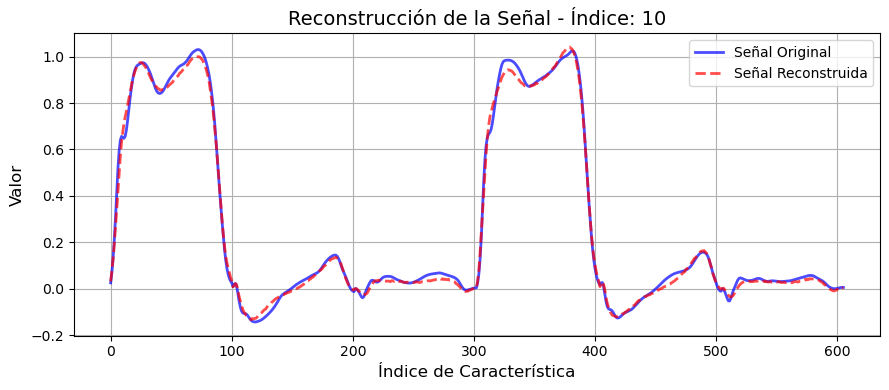

In [42]:

# Seleccionar una señal para visualizar
indice_señal = 10  # Cambia este índice para visualizar otras señales

# Llamar a la función de visualización
visualizar_reconstruccion(autoencoder, X_train_ae, indice_señal)


## Visualizacion de espacios

### Espacio original 

In [43]:
"""
# Aplicar t-SNE directamente al conjunto original X_train
tsne_original = TSNE(n_components=2, random_state=42)
X_train_2D = tsne_original.fit_transform(X_train_ae)

# Mostrar las dimensiones resultantes
print("Dimensiones originales:", X_train_ae.shape)
print("Dimensiones después de t-SNE:", X_train_2D.shape)
"""

'\n# Aplicar t-SNE directamente al conjunto original X_train\ntsne_original = TSNE(n_components=2, random_state=42)\nX_train_2D = tsne_original.fit_transform(X_train_ae)\n\n# Mostrar las dimensiones resultantes\nprint("Dimensiones originales:", X_train_ae.shape)\nprint("Dimensiones después de t-SNE:", X_train_2D.shape)\n'

In [44]:
"""
# Visualizar el conjunto original utilizando un scatter plot
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        X_train_2D[indices, 0], 
        X_train_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.5,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
"""


'\n# Visualizar el conjunto original utilizando un scatter plot\nplt.figure(figsize=(9, 6))\ncolores = [\'royalblue\', \'darkorange\']  # Colores para las clases\n\nfor i, clase in enumerate([0, 1]):\n    indices = Y_train_ae == clase\n    plt.scatter(\n        X_train_2D[indices, 0], \n        X_train_2D[indices, 1], \n        label=f\'Clase {clase}\',\n        alpha=0.5,  # Transparencia para observar superposición\n        c=colores[i],\n        edgecolor=\'w\',  # Borde blanco para mayor claridad\n        linewidth=0.5,\n        s=30  # Tamaño de los puntos\n    )\n\n# Configuración del gráfico\nplt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)\nplt.xlabel("Componente 1", fontsize=12)\nplt.ylabel("Componente 2", fontsize=12)\nplt.legend(fontsize=12, loc=\'upper right\')\nplt.grid(visible=True, linestyle=\'--\', alpha=0.5)  # Agregar una cuadrícula suave\nplt.tight_layout()\nplt.show()\n'

### Espacio latente

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Crear el encoder como modelo independiente
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_9').output)
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)  # Última capa del encoder

# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train_ae)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train_ae.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
Dimensiones de X_train_ae: (12408, 606)
Dimensiones del espacio latente: (12408, 20)


In [46]:
# Guardar el encoder
encoder.save("../Modelos/Binary_Encoder_MPL_v2.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [47]:
# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

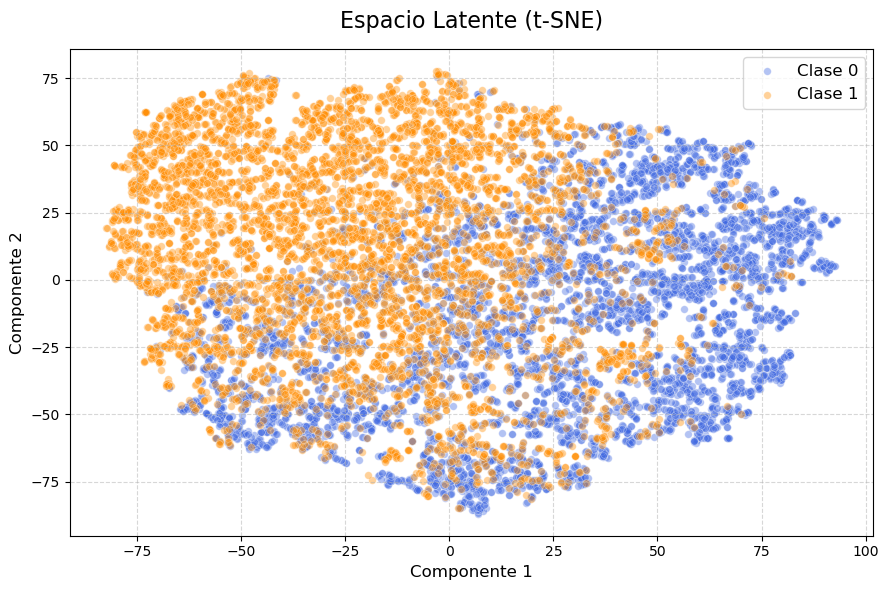

In [ ]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()